In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd

# <font color='orange'>**Data Preprocessing**

In [2]:
df = pd.read_csv('region_04.csv')

df_clean = df.dropna(subset=['latitude', 'longitude'])

columns_to_keep = ['eventid', 'iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'city', 'latitude', 'longitude', 'attacktype1_txt', 'nkill', 'nwound']
df_clean = df_clean[columns_to_keep]

# <font color='orange'>**Simple plot**

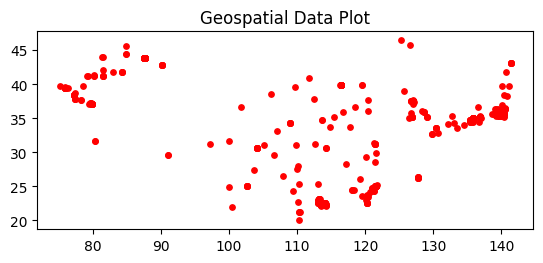

In [3]:
geometry = [Point(lon, lat) for lon, lat in zip(df_clean['longitude'], df_clean['latitude'])]

gdf = gpd.GeoDataFrame(df_clean, geometry=geometry)

gdf.plot(marker='o', color='red', markersize=15)
plt.title('Geospatial Data Plot')
plt.savefig('geospatial_data_plot.png', dpi=300)
plt.show()

In [4]:
print(gdf.head())
print(gdf.describe())

        eventid  iyear  imonth  iday country_txt region_txt      city  \
0  197001000003   1970       1     0       Japan  East Asia   Fukouka   
1  197003310002   1970       3    31       Japan  East Asia   Fukouka   
2  197111200002   1971      11    20      Taiwan  East Asia   Unknown   
3  197304250001   1973       4    25       Japan  East Asia  Yokosuka   
4  197308290001   1973       8    29       Japan  East Asia     Tokyo   

    latitude   longitude                 attacktype1_txt  nkill  nwound  \
0  33.580412  130.396361  Facility/Infrastructure Attack    NaN     NaN   
1  33.580412  130.396361                       Hijacking    0.0     0.0   
2  23.583333  119.583330               Bombing/Explosion   25.0     NaN   
3  35.281341  139.672200  Facility/Infrastructure Attack    0.0     0.0   
4  35.689125  139.747742  Facility/Infrastructure Attack    0.0     0.0   

                     geometry  
0  POINT (130.39636 33.58041)  
1  POINT (130.39636 33.58041)  
2  POINT (119.

# <font color='orange'>**Base map**

In [5]:
import folium
from folium.plugins import HeatMap
m = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=2)

for idx, row in df_clean.iterrows():
    folium.Marker([row['latitude'], row['longitude']],
                  popup=f"Event ID: {row['eventid']}<br>Attack Type: {row['attacktype1_txt']}<br>Kill: {row['nkill']}<br>City : {row['city']}",
                  icon=folium.Icon(color="red", icon="info-sign")).add_to(m)

m.save('base_map.html')
m

# <font color='orange'>**Choropleth map**

In [6]:
import json

incidents_by_country = df_clean.groupby('country_txt').size().reset_index(name='incident_count')


geojson_url = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'


m = folium.Map(location=[20, 0], zoom_start=2)


folium.Choropleth(
    geo_data=geojson_url,
    name='Incident Count by Country',
    data=incidents_by_country,
    columns=['country_txt', 'incident_count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Incident Count',
).add_to(m)

m.save('choropleth.html')
m

# <font color='orange'>**Heat map**

In [7]:
import folium
from folium.plugins import HeatMap

m_heatmap = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=2)

heat_data = [[row['latitude'], row['longitude']] for index, row in df_clean.iterrows()]

HeatMap(heat_data).add_to(m_heatmap)

m_heatmap.save('heatmap.html')

m_heatmap

# <font color='orange'>**Attack_type Analysis**

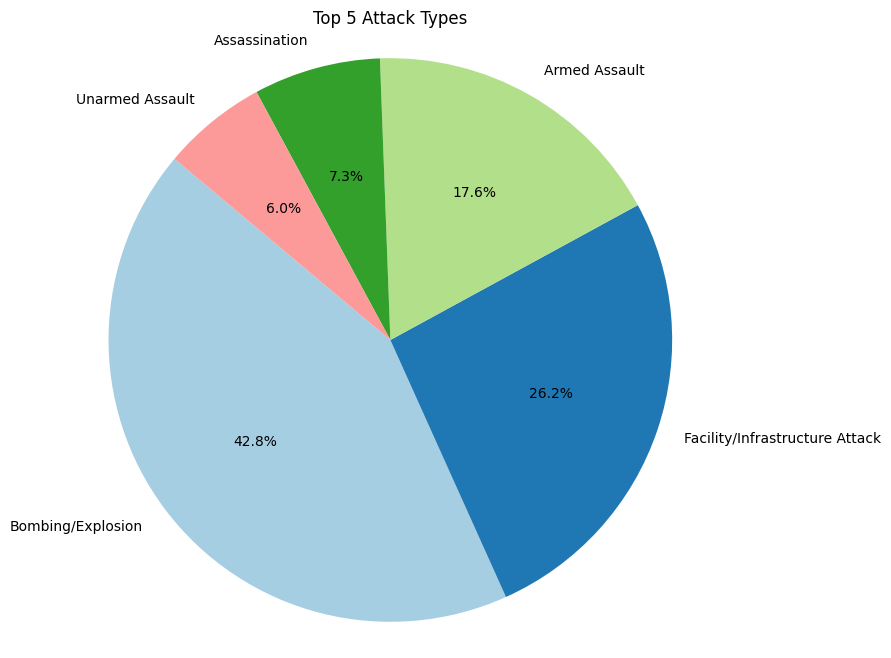

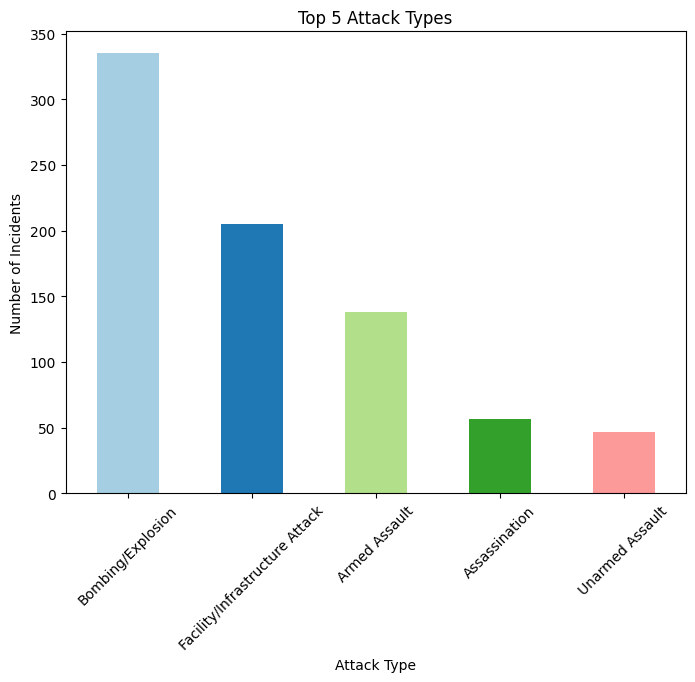

attacktype1_txt
Bombing/Explosion                      335
Facility/Infrastructure Attack         205
Armed Assault                          138
Assassination                           57
Unarmed Assault                         47
Unknown                                 21
Hijacking                               18
Hostage Taking (Kidnapping)             15
Hostage Taking (Barricade Incident)      3
Name: count, dtype: int64


In [11]:
attack_counts = df_clean['attacktype1_txt'].value_counts()

top_attack_types = attack_counts.head(5)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_attack_types, labels=top_attack_types.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 5 Attack Types')
plt.axis('equal')
plt.savefig('top_5_attack_types_pie.png')
plt.show()


# Bar chart
plt.figure(figsize=(8, 6))
top_attack_types.plot(kind='bar', color=plt.cm.Paired.colors[:5])
plt.title('Top 5 Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.savefig('top_5_attack_types_bar.png')
plt.show()

print(attack_counts)

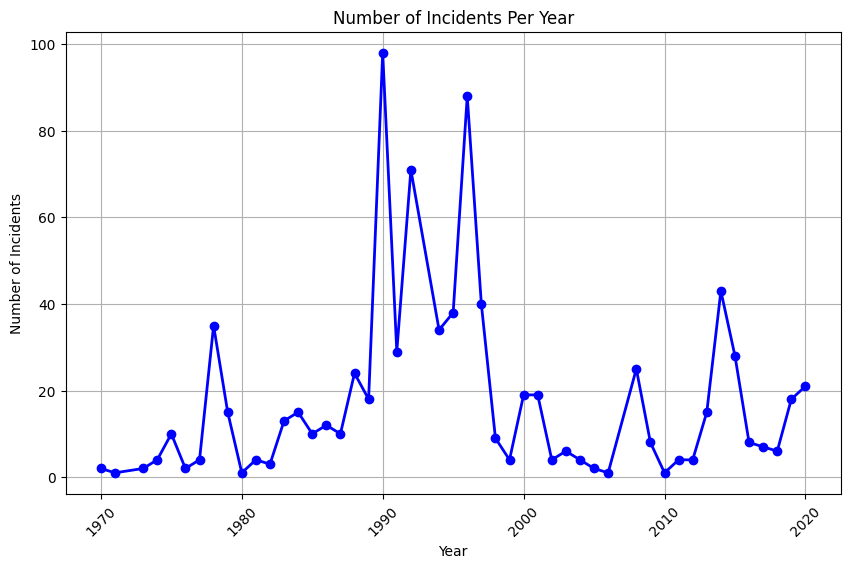

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

incidents_per_year = df_clean.groupby('iyear').size()


plt.figure(figsize=(10, 6))
plt.plot(incidents_per_year, marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Number of Incidents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('incidents_per_year.png')
plt.show()

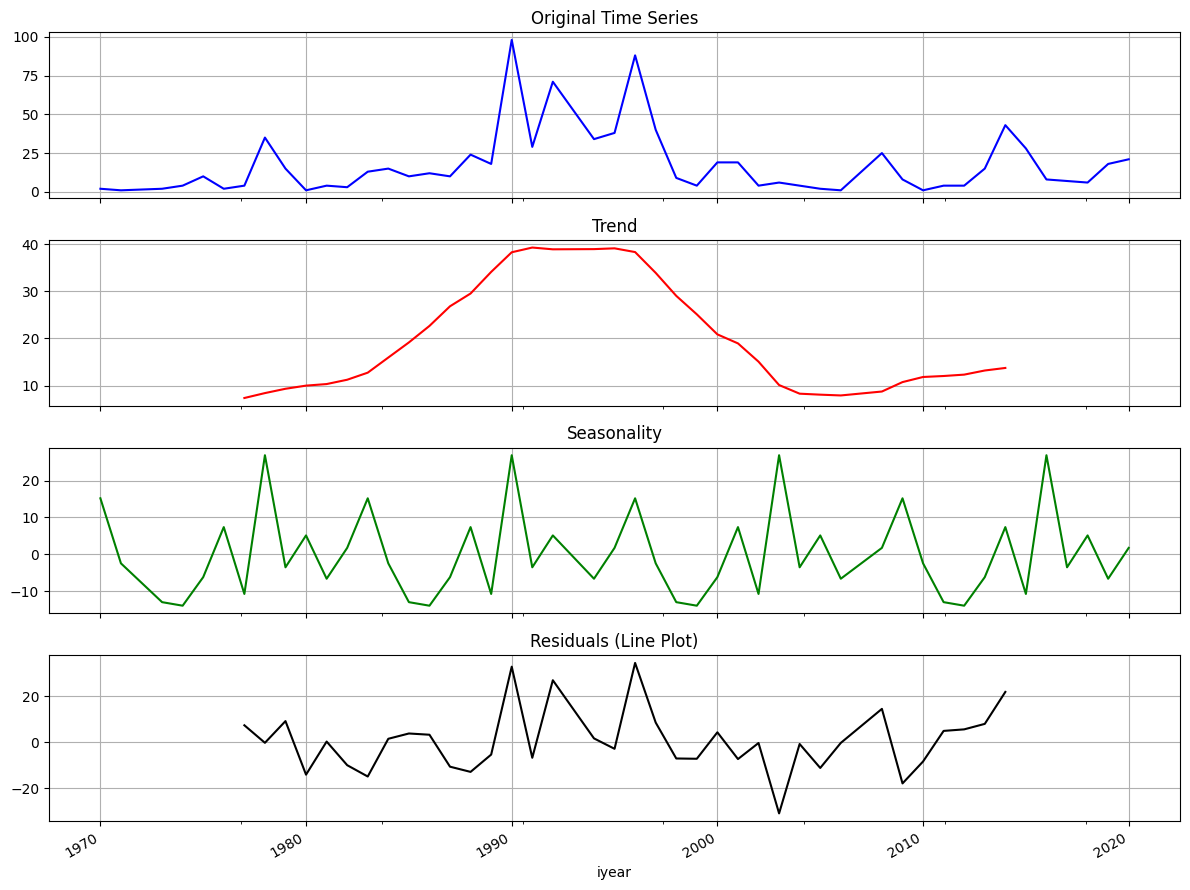

In [16]:
incidents_per_year_series = incidents_per_year.astype('float64')
incidents_per_year_series.index = pd.to_datetime(incidents_per_year.index, format='%Y')

decomposition = sm.tsa.seasonal_decompose(incidents_per_year_series, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
incidents_per_year_series.plot(ax=axes[0], title="Original Time Series", color='blue', grid=True)
decomposition.trend.plot(ax=axes[1], title="Trend", color='red', grid=True)
decomposition.seasonal.plot(ax=axes[2], title="Seasonality", color='green', grid=True)
decomposition.resid.plot(ax=axes[3], title="Residuals (Line Plot)", color='black', linestyle='-', grid=True)

plt.tight_layout()
plt.savefig('seasonal_decomposition.png', dpi=300)
plt.show()